In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

#load csv data
df = pd.read_csv('https://raw.githubusercontent.com/monu322/CustomerClassification/main/CE802_P2_Data.csv')
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,-1,45,-7.97,0.54,3,0.50,-113.34,20.30,9.99,20.50,-5.52,3.60,-466.22,1.88,-7.49,True
1,1,27,-7.02,1.08,3,0.85,-47.34,20.00,2.88,19.40,-6.49,1.22,-470.22,0.57,NaN,True
2,-2,0,-8.82,0.56,3,0.45,-152.34,19.62,9.78,20.74,-5.21,2.08,-534.22,5.62,-5.74,False
3,-14,855,-3.23,12.00,30,7.45,-341.34,34.76,-10.14,14.38,-4.79,-2.52,-846.22,-4.17,NaN,True
4,-1,39,-8.12,2.88,3,0.76,-53.34,19.08,6.48,22.58,-7.52,1.24,-512.22,2.17,NaN,False


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


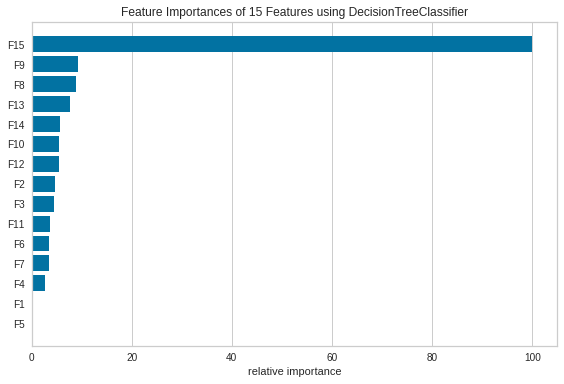

In [2]:
#finding feature importance of F15 after dropping missing value records
from yellowbrick.features import FeatureImportances

df0 = df.dropna()
X = df0.drop(['Class'], axis=1)
y = df0.Class

clf = DecisionTreeClassifier()
viz = FeatureImportances(clf)
viz.fit(X, y)
viz.poof()

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X, y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 




0.79 {'max_depth': 7}


In [17]:
#remove F15 column altogether
df1 = df.drop('F15', 1)

X = df1.drop(['Class'], axis=1)
y = df1.Class

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X, y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.7693333333333333 {'max_depth': 8}


In [18]:
#now let's remove all records with missing values
df2 = df.dropna()

X = df2.drop(['Class'], axis=1)
y = df2.Class

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X, y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 


0.7866666666666667 {'max_depth': 9}


In [6]:
#now let's try imputation of F15 with mean values

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')

df3 = df

df3.F15 = imputer.fit_transform(df3['F15'].values.reshape(-1,1))[:,0]

df3.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,-1,45,-7.97,0.54,3,0.50,-113.34,20.30,9.99,20.50,-5.52,3.60,-466.22,1.88,-7.490000,True
1,1,27,-7.02,1.08,3,0.85,-47.34,20.00,2.88,19.40,-6.49,1.22,-470.22,0.57,-7.043013,True
2,-2,0,-8.82,0.56,3,0.45,-152.34,19.62,9.78,20.74,-5.21,2.08,-534.22,5.62,-5.740000,False
3,-14,855,-3.23,12.00,30,7.45,-341.34,34.76,-10.14,14.38,-4.79,-2.52,-846.22,-4.17,-7.043013,True
4,-1,39,-8.12,2.88,3,0.76,-53.34,19.08,6.48,22.58,-7.52,1.24,-512.22,2.17,-7.043013,False


In [19]:
#checking performance of imputed dataset
X = df3.drop(['Class'], axis=1)
y = df3.Class

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X, y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.7893333333333333 {'max_depth': 7}


In [21]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB



#Removing records with missing values
df2 = df.dropna()

X = df2.drop(['Class'], axis=1)
y = df2.Class

X = np.array(X)
y = np.array(y)

#using 5-fold cross validation
kf = KFold(5, shuffle=True, random_state=42)
cv_lr_accuracy  = []


for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]

    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val) 

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_accuracy.append(accuracy_score(y_val, y_pred))

print(f'Logistic Regression CV accuracy: {np.mean(cv_lr_accuracy):.3f} +- {np.std(cv_lr_accuracy):.3f}')



Logistic Regression CV accuracy: 0.841 +- 0.005


In [22]:
cv_svm_accuracy  = []


for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]

    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val) 

    #SVM Classification
    svm_clf = svm.SVC(kernel='linear').fit(X_train_scale, y_train)
    y_pred = svm_clf.predict(X_val_scale)
    cv_svm_accuracy.append(accuracy_score(y_val, y_pred))


print(f'SVM CV accuracy: {np.mean(cv_svm_accuracy):.3f} +- {np.std(cv_svm_accuracy):.3f}')

SVM CV accuracy: 0.851 +- 0.014


In [23]:
cv_rf_accuracy  = []


for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]

    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val) 

    #Random Forest classifier
    rf_clf=RandomForestClassifier(n_estimators=200).fit(X_train_scale, y_train)
    y_pred = rf_clf.predict(X_val_scale)
    cv_rf_accuracy.append(accuracy_score(y_val, y_pred))


print(f'Random Forest CV accuracy: {np.mean(cv_rf_accuracy):.3f} +- {np.std(cv_rf_accuracy):.3f}')

Random Forest CV accuracy: 0.871 +- 0.012


In [ ]:
#as per results, Random forest has the best performance. So let's update our test data csv

#load test data
df = pd.read_csv('https://raw.githubusercontent.com/monu322/CustomerClassification/main/CE802_P2_Test.csv')
df.head()

#impute F15 missing values with mean
df.F15 = imputer.fit_transform(df['F15'].values.reshape(-1,1))[:,0]
df.head()

#divide data into features and labels
X = df.drop(['Class'], axis=1)
y = df.Class

#convert data frame into np array
X = np.array(X)
y = np.array(y)

# Standardize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#use the trained Random Forest model to predict test data labels
y_pred = rf_clf.predict(X_scaled)

df['Class'] = y_pred

#save the data frame into a csv
df.to_csv('CE802_P2_Test.csv', index = False)

df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,-4,765,-3.72,26.40,30,5.15,18.66,31.06,-4.80,15.18,-5.05,-6.56,-766.22,-1.98,-4.670000,False
1,-3,3,-7.10,1.20,3,0.36,-119.34,20.00,6.39,19.92,-5.29,0.32,-524.22,2.12,-7.076347,True
2,-4,735,-1.70,14.50,30,6.50,183.66,37.36,-11.88,11.22,-7.79,-9.64,-776.22,-3.88,-6.570000,False
3,-14,90,-2.55,13.30,30,7.95,-236.34,32.06,-3.09,15.86,-4.33,-8.76,-916.22,-3.41,-7.076347,False
4,-1,174,-7.63,3.74,3,0.94,-143.34,19.58,11.67,19.62,-7.63,1.12,-506.22,3.08,-7.076347,False
